# Indexing and searching microbiome data using HULK sketches

***

## Commands used to download the data

* Download the HMP metagenome shotgun sequencing data (that passed QC)

```bash
#!/usr/bin/env bash

# README:
#
# This script will automate the
#

# SETUP:
#
# I use a conda environment to get all the software I need
#
# conda create -n fastq && source activate fastq
# conda install -c bioconda sra-tools entrez-direct
#

# get the 690 HMP samples that passed QC (https://www.hmpdacc.org/HMASM/#data)
wget https://www.hmpdacc.org/hmp/HMASM/HMASM-690.csv -O hmp-samples.csv

# this command does a few things:
# 1. takes the sample number from the hmp-samples list, then strips the inverted commas
# 2. it searches for the linked run IDs (SRR numbers)
# 3. it then takes only the linked Illumina run(s)
# 4. it then downloads the FASTQ files for the run(s)
cut -f 1 hmp-samples.csv -d "," | sed s/\"//g | parallel --gnu -j 20 "esearch -db sra -query {}  | efetch --format runinfo | grep 'ILLUMINA' | cut -d ',' -f '1' | xargs fastq-dump --split-files --gzip"

# clear the sra cache
clear ~/ncbi/public/sra/*
```

## Commands used to generate the sketches

* Histosketch each HMP sample

``` bash

```

## Commands used to generate and search the index

* Make a separate directory to split the queries from the other sketches

```
cd data/2.indexing/ && mkdir cami-queries
```

* Get one query from each body site and then move it to the queries pile

```
for i in cami-sketches/*; do mkdir cami-queries/${i##*/}; ls $i | sort -R | tail -n 1 | xargs -I {} sh -c "mv $i/{} cami-queries/${i##*/}"; done
```

* Create an index of the CAMI sketches, using a Jaccard Similarity theshold of 90%

```
hulk index -r create -n cami.index -j 0.90 -d ./cami-sketches/ --recursive
```

* Search the index using our queries

```
hulk index -r search -n cami.index -j 0.90 -d cami-queries/ --recursive > hulk-search-results.txt
```

## Commands used to generate the feature matrix from the sketches

* For each label in `data/cami-sketches`, generate a bannerMatrix of features e.g.:

```
for i in cami-sketches/*
do
site=${i##*/}
hulk smash --bannerMatrix -d ${i}/ -o ${site} -l ${site}
done
```

* Now get a matrix of all the queries, then add them to the previous file:

```
for i in cami-queries/*/*.sketch
do
fn=${i##*/*/}
hulk print -f ${i} | sed s/cami-queries.*/q-${fn}/g >> queries.csv
done
```

* Combine the CSVs:

```
cat *.csv > labelled-sketches.csv && rm *.banner-matrix.csv
```

In [296]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

sns.set_style('whitegrid', rc={'figure.figsize':(11.7,8.27)})

In [297]:
# Load the sketches
df = pd.read_csv("data/2.indexing/labelled-sketches.csv", header=None)

In [298]:
# Separating out the label
y = df.loc[:, [len(df.columns)-1]].values

# Separating out the features
x = df.loc[:, 0:len(df.columns)-2].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

/Users/willrowe/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [304]:
# PCA projection
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[[len(df.columns)-1]]], axis = 1)
finalDf = finalDf.rename(columns={512: 'label'})

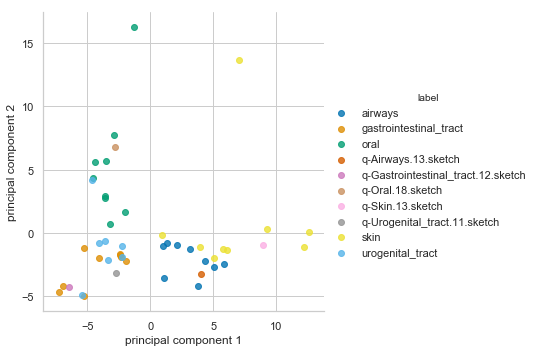

In [302]:
# Plot the PCA
## get safe colours
labels = finalDf.label.unique()
pal = sns.color_palette("colorblind", len(labels))

## plot
sns.lmplot(x='principal component 1', y='principal component 2', data=finalDf, fit_reg=False, hue='label', palette=pal) 

In [1]:
# To generate the final figure, I overlayed the sample names and drew red circles around LSH Forest search results. Queries (q-) were relabelled to stars. 